In [3]:
import torch
import numpy as np
import numbers
import math
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import scipy.stats as stats
from scipy.ndimage import uniform_filter1d

## This notebook is used to create data for figure 3 and SI figure 7

In [4]:
def make_sase(
    npoints: int,
    sparsity: float,
    bandwidth: float = 1.0,
    nshots: int = 1,
    center: float = 0.0,
    normalize = 'max',
):
    """
    Generate fake SASE spectra with tunable "sparsity", i.e. number of spikes per spectrum.
    Higher sparsity number indicates more spikes, lower indicates fewer.
    
    Args:
        npoints (int): number of points to generate for axis in range [-1., 1.]
        sparsity (float): a "sparsity" parameter for the SASE in number of spikes per bin
        bandwith (float): the Gaussian envelope width in FWHM on the range [-1., 1.]
        nshots (int): number of shots to generate
        modulate_power: whether to model power fluctuations (default False)
        normalize: we can normalize by 'l2', 'power', 'max', with default = 'max'. 'l2' makes it 
                    so that each shot has unit euclidean norm, 'power' ensures that
                    the sum of each shot is 1, and 'max' ensures that the peak spectral
                    intensity is 1 for the whole dataset. 'max' is default since it makes the 
                    most physical sense to me and results in the best correlation between
                    sparsity and coherence
    """

    axis = np.linspace(-1, 1, npoints).reshape(-1, 1)
    bandwidth = bandwidth / 2.355  # convert from FWHM
    envelope = stats.norm.pdf(axis, scale=bandwidth, loc=center)
    Xni = stats.gamma.rvs(
        a=sparsity * envelope, scale= 1, size=(len(axis), nshots)
    ).T
    
    if normalize == "l2":
        Xni /= np.sqrt((Xni**2).sum(-1))[:,None]
    elif normalize == "power":
        Xni /= Xni.sum(-1)[:,None]
    elif normalize == "max":
        Xni /= Xni.max()

    return uniform_filter1d(Xni,3,-1)

In [5]:
def first_moment(axis, specs):
    return (axis[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)

def thresh_clean(X, thresh=0.01):
    X = np.copy(X)
    Xm = X/X.max()
    mask = Xm<thresh
    X[mask] *= 0
    return X

def blank_shot_mask(X, thresh=0.01):
    Xm = X/X.max()
    return np.any(X>thresh, axis=-1)

def discrete_gaussian(kernel_size, dim, sigma, dtype=torch.float32):
    if isinstance(kernel_size, numbers.Number):
        kernel_size = [kernel_size] * dim
    if isinstance(sigma, numbers.Number):
        sigma = [sigma] * dim
    kernel = 1
    meshgrids = torch.meshgrid(
        [
            torch.arange(size, dtype=dtype)
            for size in kernel_size
        ]
    )
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                  torch.exp(-((mgrid - mean) / std) ** 2 / 2)
        
    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)
    return kernel

class GaussianSmoothing(torch.nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = discrete_gaussian(kernel_size, dim, sigma, dtype=self.dtype)
        
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

def batch_filter_2D(imgs, sigma, filter_size=5):
    """imgs interpreted to be a batch of images, with -1 dim being roi dim and -2 dim being out dim,
        -3 being batch dim"""
    assert imgs.dim() == 3
    assert filter_size % 2 > 0
    padlen = (filter_size - 1)//2
    smoother = GaussianSmoothing(1, filter_size, sigma, dim=2, dtype=imgs.dtype)
    inp = F.pad(imgs, (padlen, padlen, padlen, padlen), mode='constant')
    output = smoother(inp.unsqueeze(1)) #unsqueeze to insert channel dim
    return output

def add_readnoise(img, noise_in_photons):
    if torch.is_tensor(img):
        z = torch.empty_like(img).normal_()*noise_in_photons
        return img + z
    else:
        z = torch.empty_like(torch.from_numpy(img)).normal_()*noise_in_photons
        return (img + z).cpu().detach().numpy()

def add_poisson_noise(x, alpha: float):
    if torch.is_tensor(x):
        return torch.from_numpy(np.random.poisson(x.detach().cpu().numpy() * alpha)).type(x.dtype).to(x.device)
    else:
        return np.array(np.random.poisson(x * alpha), x.dtype)
    
def add_2D_cs_noise_to_vector_data(x, alpha: float, noise_in_photons: float, 
                                                     blur_radius_in_pixels: float, filter_size=5, roi_width=20,
                                                    debug=False):
    """
    x expected to be 2D, with shape N x D, i.e. shots by output pixels. The values in x are interpreted to be
    photon rates.
    
    This vector is expanded to N x D x roi_width. We adjust the rate according to a gaussian profile, along the
    spatial direction (i.e. the new expanded dimension) to simulate a focused von Hamos emission pattern. This
    should give variable rates of charge sharing effect across the roi.
    
    Then the photons (now treated as ADUs) blurred according to the specified blur_radius_in_pixels, which uses a
    gaussian blur.
    
    Then, read noise (gaussian noise) is added to that, with the amount specified by "noise_in_photons", which
    indicates that you should give a fractional photon as the unit, e.g. 1/8 of a photon is typical.
    
    Finally, the ROI dim is sum reduced to simulate integration over a spatial dimension in the usual von Hamos
    style of data collection.
    
    To skip any one of these 3 steps, you can set the corresponding control variable to some negative number. So,
    pure poisson = alpha > 0, noise_in_photons < 0, blur_radius_in_pixels < 0
    pure gaussian = alpha < 0, noise_in_photons >0,  blur_radius_in_pixels < 0
    """
    assert len(x.shape)==2
    assert filter_size % 2 > 0
    flag = False
    if not torch.is_tensor(x):
        flag = True
        x = torch.from_numpy(x)
    D = x.shape[-1]
    x = x.unsqueeze(-1).expand(-1, D, roi_width)/roi_width
    #this width (roi/6) makes the edge pixel about 50x weaker than center pixels
    f = discrete_gaussian(roi_width, 1, roi_width/6, dtype=x.dtype)
    x = f[None,None,:]*x #apply the filter to simulate focused light
    if alpha > 0:
        photons = add_poisson_noise(x, alpha)
        latent = x*alpha
    else:
        photons = x
        latent = x
    if debug:
        figure()
        imshow(photons[0,:,:])
    if blur_radius_in_pixels > 0:
        blurred_photons = batch_filter_2D(photons, blur_radius_in_pixels, filter_size=filter_size)
        blurred_latent = batch_filter_2D(latent, blur_radius_in_pixels, filter_size=filter_size)
    else:
        blurred_photons = photons.unsqueeze(1) #add channel dim
        blurred_latent = latent.unsqueeze(1)
    if debug:
        figure()
        imshow(blurred_photons[0,0,:,:])
    if noise_in_photons > 0:
        noisy_adu = add_readnoise(blurred_photons, noise_in_photons/np.sqrt(roi_width))
        latent_adu = blurred_latent
    else:
        noisy_adu = blurred_photons
        latent_adu = blurred_latent
    result = noisy_adu.sum(dim=-1)
    latent_result = latent_adu.sum(dim=-1)
    if flag:
        return result[:,0,:].numpy(), latent_result[:,0,:].numpy()
    else:
        return result[:,0,:], latent_result[:,0,:]

In [6]:
def simulate_detector_response(sase_shots,
                       herfd,
                       emission,
                       mean_photon_rate = 10,
                       read_noise = 1/4, 
                       cs_radius_in_pixels=1.,
                       batch_size = 40000):
    """ A quick and dirty simulation, where the rixs plane is just the outer product of the herfd spectrum 
        and the emission spectrum. Father, forgive me for these sins."""
    herfd = herfd[:,None] / herfd.max()
    emission = (emission[None,:]/emission.max())
    rixs = np.clip(herfd * emission, a_min=0., a_max=None)
#     sase_shots = sase_shots/np.sum(sase_shots, axis=1).mean()
    Y = sase_shots @ rixs
    
#     c = Y[:].mean() # sets mean photon rate to 1, so now mean_photon_rate is given to alpha
    # there seems to be memory issues on my machine associated with simulating many shots. So I limit it 
    # to batches of 40k shots.
    ys = TensorDataset(torch.from_numpy(Y))
    ys_loader = DataLoader(ys, batch_size=batch_size)
    Ycs = []
    for ys in ys_loader:
        Ycs.append(add_2D_cs_noise_to_vector_data(ys[0], alpha=mean_photon_rate, noise_in_photons=read_noise,
                                        blur_radius_in_pixels=cs_radius_in_pixels))
    Yc = np.concatenate([x[0].numpy() for x in Ycs],0)
    Lc = np.concatenate([x[1].numpy() for x in Ycs],0)
    # returning the sase_shots in case our sum normalization affected them, so that reconstruction algorithms
    # should now give the right answer. The last return is the ground truth with appropriate scaling adjustments
    # made so that it should match the reconstructed answer.
    return sase_shots, Yc, rixs, Lc

In [7]:
from matplotlib.pyplot import *
import h5py
import sys
sys.path.append('/home/fdfuller/work/verified/stochastic_spectroscopy/')
from stochastic_spectroscopy.reference_spectra import *
%matplotlib notebook

In [8]:
dname = 'clean_sorted_200mM_ferrocyanide_pink_all'
with h5py.File('/home/fdfuller/work/data/sacla2017/' + dname + '.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])
    out_axis = np.array(fid['out_axis_binned'])
    Xpinka = np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64')
    Xpinkb = np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')
    Xpink = np.concatenate([Xpinka, Xpinkb],0)
    Xpink /= Xpink.max()
    Xpink = np.clip(Xpink, a_min=0., a_max=None)
    Ypinka = np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64')
    Ypinkb = np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')
    Ypink = np.concatenate([Ypinka, Ypinkb],0)
    Ypink /= Ypink.max()

# filter out extreme first moment values
mu1all = first_moment(inp_axis, Xpink)
si = np.argsort(mu1all)
Xpink = Xpink[si,:][17000:187000,:]
Ypink = Ypink[si,:][17000:187000,:]

# no adjust (i.e. no elastic correction), nor any other corrections (old). Simply what we measured
Xpink_old_no_adj = np.copy(Xpink)
Ypink_old_no_adj = np.copy(Ypink)
Xpink_old_no_adj = np.clip(Xpink_old_no_adj, a_min=0., a_max=None)
mu1all_old_no_adj = first_moment(inp_axis, Xpink_old_no_adj)
siona = np.argsort(mu1all_old_no_adj)
Xpink_old_no_adj = Xpink_old_no_adj[siona,:]
Ypink_old_no_adj = Ypink_old_no_adj[siona,:]

In [9]:
def G(x, alpha):
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / alpha\
                             * np.exp(-(x / alpha)**2 * np.log(2))

def L(x, gamma):
    """ Return Lorentzian line shape at x with HWHM gamma """
    l = 1 / ((np.pi*gamma)*(1 + x**2/gamma**2))
    return l/l.max()

def static_profile_correction(X, inp_axis, center, width):
    return X*L(inp_axis - center, width/2)[None,:]

def reverse_static_profile_correction(X, inp_axis, center, width):
    return X/L(inp_axis - center, width/2)[None,:]

In [19]:
# Simulate the data
Xnorm_old_no_adj, Ysim_old_no_adj, ground_truth_old_no_adj, latent_targets_old_no_adj = \
                                simulate_detector_response(Xpink_old_no_adj,
                                                          ferro_spline(inp_axis), 
                                                          (500/2)*Ypink_old_no_adj.mean(0),
                                                          mean_photon_rate=1050,
                                                          read_noise=1/5,
                                                          cs_radius_in_pixels=0.42)

## SI Figure 7b

<IPython.core.display.Javascript object>


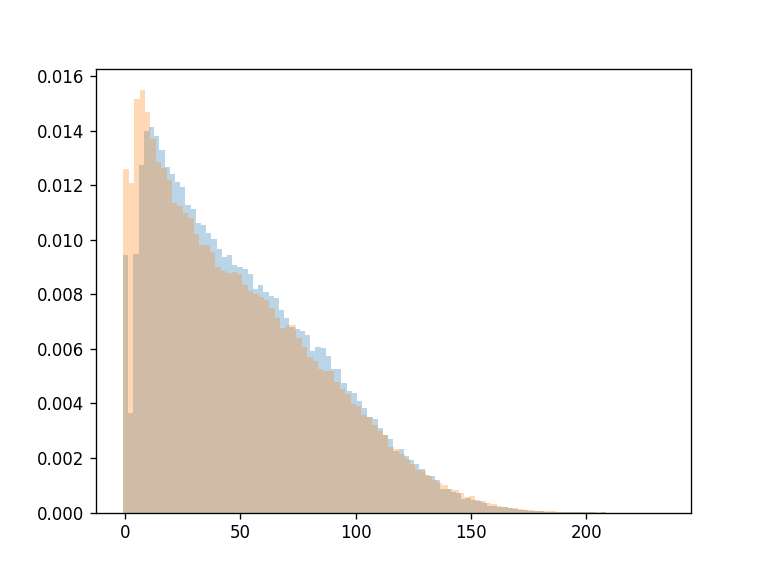

In [15]:
figure()
p = 13
hist(Ysim_old_no_adj[:,p],100, density=True,alpha=0.3);
hist((500/2)*Ypink_old_no_adj[:,p], 100, density=True,alpha=0.3);

In [18]:
with h5py.File('./fake_data/trimmed_old_unthreshed_no_adj_data_run1.h5','w') as fid:
    fid.create_dataset('X', data=Xnorm_old_no_adj)
    fid.create_dataset('Y', data=Ysim_old_no_adj/250)
    fid.create_dataset('Yreal', data=Ypink_old_no_adj)
    fid.create_dataset('Xreal', data=Xpink_old_no_adj)
    fid.create_dataset('gt', data=ground_truth_old_no_adj)